In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import os
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers

from keras.layers import (
    GlobalAveragePooling2D, Flatten, GlobalMaxPooling2D, Dense,
    Reshape, Add, Multiply, Conv2D, Activation, Concatenate
)
from keras.optimizers.schedules import CosineDecay
from keras.callbacks import Callback
import keras.backend as K

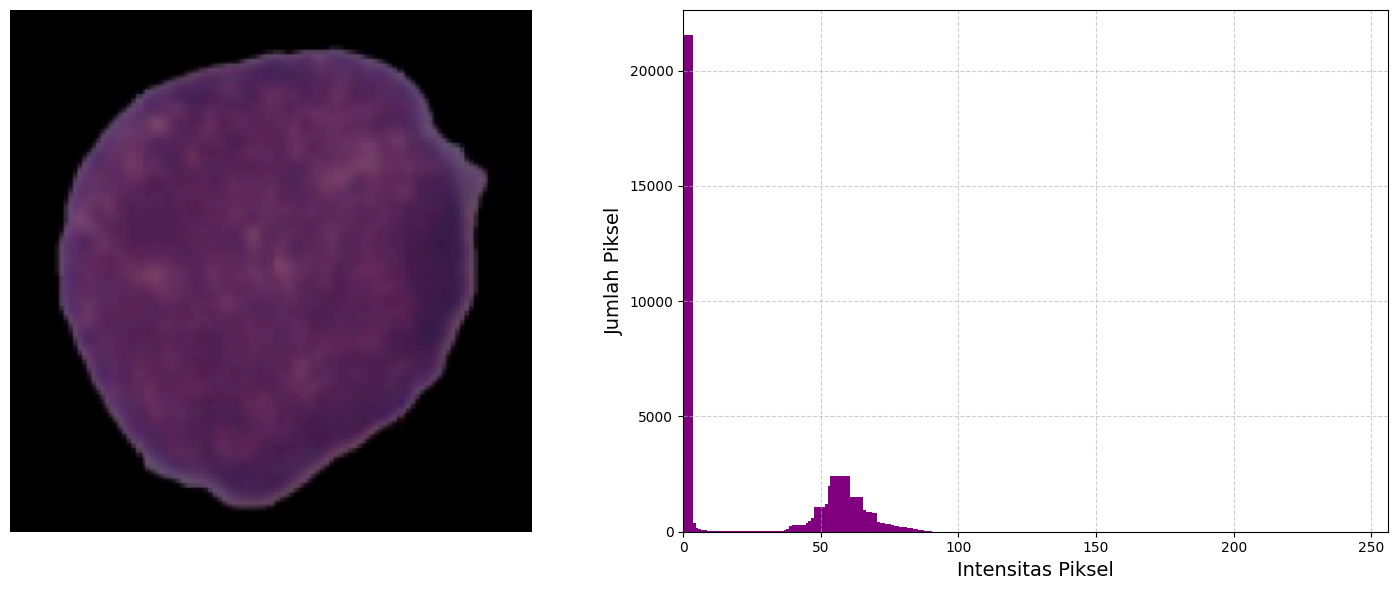

In [ ]:
# Pastikan Anda mengganti path gambar dengan path yang benar
image_path = r'D:\SKRIPSI\SKRIPSI LEUKEMIA\References Leukemia\Gambar\hem hist.png'

try:
    # Membaca gambar
    img = cv2.imread(image_path)

    # Memeriksa apakah gambar berhasil dimuat
    if img is None:
        raise FileNotFoundError(f"Tidak dapat memuat gambar dari {image_path}. Pastikan path file benar.")

    # Mengubah ukuran gambar menjadi 224x224
    # cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
    # src: gambar sumber
    # dsize: ukuran output (lebar, tinggi)
    # interpolation: metode interpolasi (INTER_AREA untuk pengecilan, INTER_CUBIC/INTER_LINEAR untuk pembesaran)
    resized_img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

    # Mengubah gambar yang sudah di-resize menjadi skala keabuan jika gambar berwarna
    if len(resized_img.shape) == 3: # Jika gambar memiliki 3 channel (berwarna)
        gray_resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    else: # Jika gambar sudah dalam skala keabuan
        gray_resized_img = resized_img

    # Menghitung histogram dari gambar yang sudah di-resize (skala keabuan)
    hist = cv2.calcHist([gray_resized_img], [0], None, [256], [0, 256])

    # Membuat figure dengan dua subplot (1 baris, 2 kolom)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # figsize disesuaikan agar cukup lebar

    # Subplot pertama untuk menampilkan gambar yang sudah di-resize
    axes[0].imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)) # Konversi BGR ke RGB untuk tampilan Matplotlib
    axes[0].axis('off') # Sembunyikan sumbu

    # Subplot kedua untuk menampilkan histogram
    axes[1].set_xlabel("Intensitas Piksel", fontsize=14)
    axes[1].set_ylabel("Jumlah Piksel", fontsize=14)
    axes[1].bar(np.arange(256), hist.ravel(), color='purple', width=7) # width=1 agar batang saling berdempetan
    axes[1].set_xlim([0, 256])
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Menyesuaikan layout agar tidak ada tumpang tindih
    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"Terjadi kesalahan: {e}")

In [2]:
def create_df(dataset):
    image_paths = []  
    labels = []

    for dirpath, dirnames, filenames in os.walk(dataset):
        print(f"Looking in directory: {dirpath}")  
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')): 
                image = os.path.join(dirpath, filename)
                image_paths.append(image)
                label = os.path.basename(dirpath)
                labels.append(label)
    
    df = pd.DataFrame({'Image Path': image_paths, 'Label': labels}) 
    return df

train_dir = r"D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C-NMC-LEUKEMIA"
df = create_df(train_dir)
df

Looking in directory: D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C-NMC-LEUKEMIA
Looking in directory: D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C-NMC-LEUKEMIA\training_data
Looking in directory: D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C-NMC-LEUKEMIA\training_data\all
Looking in directory: D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C-NMC-LEUKEMIA\training_data\hem


,Image Path,Label
0,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,all
1,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,all
2,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,all
3,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,all
4,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,all
...,...,...
14539,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,hem
14540,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,hem
14541,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,hem
14542,D:\SKRIPSI\SKRIPSI LEUKEMIA\DATASET\BALANCED C...,hem


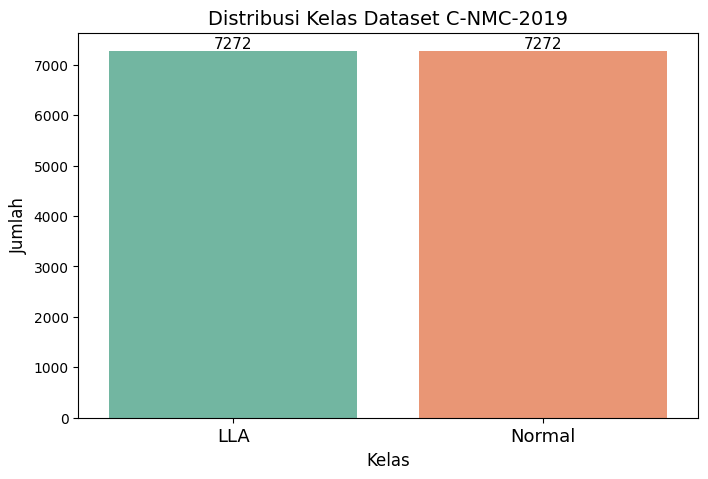

In [ ]:
# Buat DataFrame dari hasil value_counts
label_counts_df = df['Label'].value_counts().reset_index()
label_counts_df.columns = ['Label', 'Jumlah']

# Plot dengan hue = Label
plt.figure(figsize=(8, 5))
sns.barplot(data=label_counts_df, x=['LLA', 'Normal'], y='Jumlah', hue='Label', palette='Set2', legend=False)

# Tambahkan judul dan label sumbu
plt.title("Distribusi Kelas Dataset C-NMC-2019", fontsize=14)
plt.xlabel("Kelas", fontsize=12)
plt.ylabel("Jumlah", fontsize=12)
plt.xticks(fontsize=13)

# Tampilkan nilai di atas batang
for i, v in enumerate(label_counts_df['Jumlah']):
    plt.text(i, v + 50, str(v), ha='center', fontsize=11)

plt.show()

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, 
                                     random_state=42, stratify=df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))

Number of training samples: 11635
Number of test samples: 2909


In [18]:
train_datagen = ImageDataGenerator(
    rescale = 1 / 255.0,
)
test_datagen = ImageDataGenerator(
    rescale = 1 / 255.0,
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=40,
    class_mode='binary',
    shuffle=True
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=40,
    class_mode='binary',
    shuffle=False
)

Found 11635 validated image filenames belonging to 2 classes.
Found 2909 validated image filenames belonging to 2 classes.


In [19]:
inceptionv3_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                      weights="imagenet", 
                                                      input_shape=(224, 224, 3))
inceptionv3_model.trainable = False

In [ ]:
def cbam_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    
    # ----- Channel Attention -----
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = GlobalMaxPooling2D()(input_tensor)
    
    shared_dense_one = Dense(channels // reduction_ratio, activation='relu')
    shared_dense_two = Dense(channels)
    
    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))
    
    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_attention = Reshape((1, 1, channels))(channel_attention)
    x = Multiply()([input_tensor, channel_attention])
    
    # ----- Spatial Attention -----
    avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', 
                               activation='sigmoid')(concat)
    refined_feature = Multiply()([x, spatial_attention])
    
    return refined_feature


In [ ]:
inputs = inceptionv3_model.input

# Ambil output terakhir dari model InceptionV3
x = inceptionv3_model.output

# Terapkan CBAM setelah ekstraksi fitur selesai
x = cbam_block(x)

# Lanjutkan ke tahap klasifikasi
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Bangun model akhir
model = Model(inputs=inputs, outputs=outputs)

epochs = 15
steps_per_epoch = len(train_generator)
total_steps = steps_per_epoch * epochs

lr_schedule = CosineDecay(
    initial_learning_rate=0.0001,
    decay_steps=total_steps
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_95[0][0]']              
 ormalization)                  )                                                           

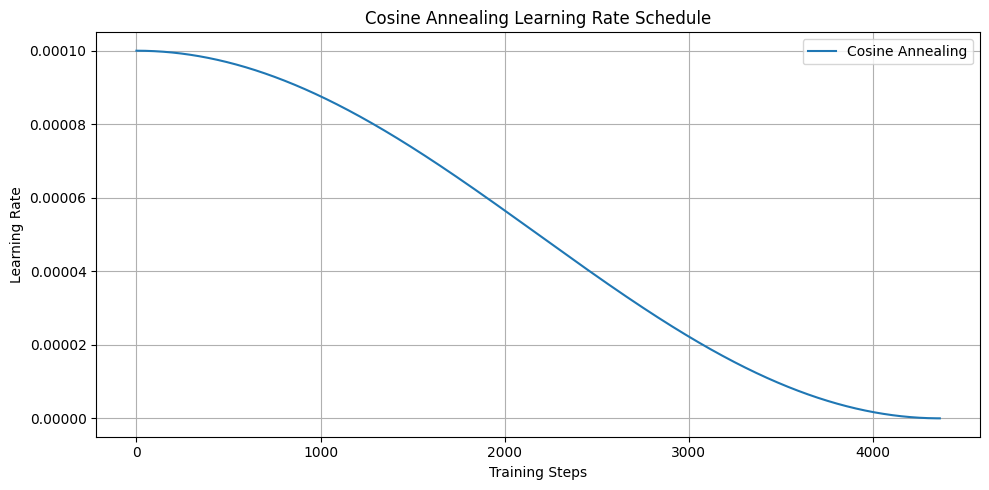

In [ ]:
# Simulasi parameter training
initial_lr = 0.0001
epochs = 15
steps_per_epoch = len(train_generator)
total_steps = epochs * steps_per_epoch

# Buat scheduler CosineDecay
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=total_steps,
    alpha=0.0  # nilai akhir akan turun ke 0
)

# Ambil nilai learning rate di setiap step
lrs = [lr_schedule(step).numpy() for step in range(total_steps)]

# Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(range(total_steps), lrs, label='Cosine Annealing')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
class LRTensorBoardCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.lr)
        print(f"Epoch {epoch + 1}: Learning rate = {lr:.8f}")

In [24]:
lr_callback = LRTensorBoardCallback()

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=len(test_generator)
    # callbacks=[lr_callback]
)


Epoch 1/15
291/291 [==============================] - 395s 1s/step - loss: 0.3288 - accuracy: 0.8563 - val_loss: 0.3019 - val_accuracy: 0.8725
Epoch 2/15
291/291 [==============================] - 386s 1s/step - loss: 0.2708 - accuracy: 0.8873 - val_loss: 0.2894 - val_accuracy: 0.8824
Epoch 3/15
291/291 [==============================] - 391s 1s/step - loss: 0.2342 - accuracy: 0.9033 - val_loss: 0.2714 - val_accuracy: 0.8862
Epoch 4/15
291/291 [==============================] - 391s 1s/step - loss: 0.1895 - accuracy: 0.9220 - val_loss: 0.2794 - val_accuracy: 0.8879
Epoch 5/15
291/291 [==============================] - 399s 1s/step - loss: 0.1506 - accuracy: 0.9410 - val_loss: 0.2929 - val_accuracy: 0.8927
Epoch 6/15
291/291 [==============================] - 404s 1s/step - loss: 0.1119 - accuracy: 0.9582 - val_loss: 0.3054 - val_accuracy: 0.8927
Epoch 7/15
291/291 [==============================] - 402s 1s/step - loss: 0.0795 - accuracy: 0.9716 - val_loss: 0.3643 - val_accuracy: 0.8835

In [ ]:
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

73/73 [==============================] - 59s 799ms/step


In [26]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

         all       0.89      0.92      0.90      1455
         hem       0.92      0.88      0.90      1454

    accuracy                           0.90      2909
   macro avg       0.90      0.90      0.90      2909
weighted avg       0.90      0.90      0.90      2909



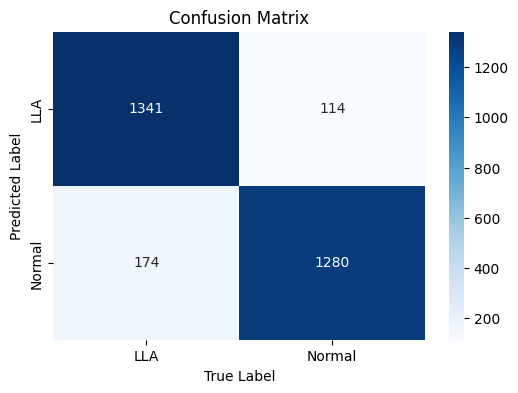

In [27]:
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Visualisasi confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['LLA', 'Normal'], yticklabels=['LLA', 'Normal'])

plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()


In [33]:
model.save('modelfix_lla_inception_cbam.keras', save_format='keras')